### Vertical Cross Section
https://wrf-python.readthedocs.io/en/latest/plot.html

In [39]:
import os, sys, datetime, string
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/MEPS/')
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/research_Haukeli/Python/WRF_python/src/')
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/research_Haukeli/Python/WRF_python/wrapt/src/wrapt')
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import simps

import createFolder as cF
#from matplotlib.cm import get_cmap
import matplotlib as mpl

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
import pandas as pd

from metpy.interpolate import cross_section
from mpl_toolkits.basemap import Basemap, cm

import matplotlib.colors as colors

import gdal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
import pandas as pd
from matplotlib.colors import LightSource
from pyproj import Proj, transform

import fcts_read_stat as rs


In [40]:
station = 'Haukeliseter'
savefig = 0
if savefig == 1:
    figdir = '../../Figures/Norway_map/%s/MEPS' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

In [41]:
thredds      = 'http://thredds.met.no/thredds/dodsC/meps25epsarchive'
year = '2016'
month = '12'
day = '24'
met_files = ['meps_mbr0_pp_2_5km_',
             'meps_subset_2_5km_',
             'meps_mbr0_full_backup_2_5km_'
            ]
forecasttime = '00'

In [42]:
def find_station_yx(latitude, longitude, stn_lat, stn_lon):
# find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
# This tells us how close a point is to the particular latitude and longitude.
    abslat = np.abs(latitude[:,:]-stn_lat)
    abslon = np.abs(longitude[:,:]-stn_lon)

# Now we need to combine these two results. We will use numpy.maximum, which takes two arrays and finds the local 
# maximum.
    c = np.maximum(abslon, abslat)

# If you don't like flattened arrays, you can also get the row/column index like this
    y, x = np.where(c == np.min(c))
    return(x,y);


In [43]:
def Lambert_map(lllon, lllat, urlon, urlat, lat0, lon0, res='l', fill=False, zoom=False):
    """lllon - lon lower left corner ...
    lat0 - latitude standard parallel, should be somewhere in the center of the domain
    lon0 - the parallel longitude
    lllon - lower left longitude ...
    http://matplotlib.org/basemap/api/basemap_api.html"""
    rsphere=(6378137.00,6356752.3142)
    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
            resolution=res,area_thresh=1000.,projection='lcc', lat_0=lat0,lon_0=lon0)
#    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
 #           resolution=res,area_thresh=1000.,projection='lcc', lat_1=lllon,lon_0=lon0)
    # Draw the latitudes and the longitudes
#    parallels = np.arange(0.,90,5.)
 #   map.drawparallels(parallels,labels=[True,False,False,False],fontsize=16)    
  #  meridians = np.arange(10.,361.,10.)
   # map.drawmeridians(meridians,labels=[False,False,False,True],fontsize=16)
    if zoom == False:
        map.drawmeridians(np.arange(0,90,10),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(10,361,4),labels=[1,0,0,0],fontsize=16)
    else:
#        map.drawmeridians(np.arange(0,90,3),labels=[0,0,0,1],fontsize=16)
 #       map.drawparallels(np.arange(0,361,2),labels=[1,0,0,0],fontsize=16)
        map.drawmeridians(np.arange(0,90,0.1),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(0,361,0.05),labels=[1,0,0,0],fontsize=16)

    # Draw the coastline
    map.drawcoastlines()#color='0.5')
    
    

    if fill:
        map.drawlsmask(#land_color='0.8', 
            ocean_color='gainsboro')
    
#    if zoom == False:
    
    ### plot MEPS area
 #       for i in range(0,lato.shape[0],12):
  #          xs, ys = map(lono[i], lato[i])
   #         map.plot(xs,ys, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)
    #    for i in range(0,lato2.shape[0],12):
     #       xs2, ys2 = map(lono2[i], lato2[i])
      #      map.plot(xs2,ys2, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)

       # xs, ys = map(lono[739], lato[739])
        #map.plot(xs,ys, color = 'orange', marker ='o', markersize = 10, linestyle = '-', linewidth = 10, label = 'MEPS domain')
        #lgd = plt.legend(loc='lower left',fontsize=18)

    #map.drawmapboundary(fill_color='gainsboro')
        
    return map    


In [44]:
def PlotContours(Lon, Lat, psurf, map, nrlevels=10, leveldist=None,levels=None, numbers=True, color= 'k'):
    """ contours for example the pressure
    nrlevels - gives the number of displayed levels
    leveldist - gives distance between levels, if specified the nlevels is ignored
    levels - can be an array that specifies the levels to display, if specified nrlevels and leveldist are ignored
    numbers - True if the contours are labeled
    color - color of the contours (None is s color map)"""
    if levels is not None:
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)
    elif leveldist is not None:
        levels= np.arange(np.round(np.min(psurf)- np.min(psurf)%leveldist), np.round(np.max(psurf)+ leveldist), leveldist)
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)        
    else:
        cs= map.contour(Lon, Lat, psurf, nrlevels, linewidths= 1. , colors= color)#, colors= 6*['b']+ 6*['r'],)
    if numbers == True: plt.clabel(cs, fontsize=10, inline=1, fmt='%1.0f', color= 'black')
    #plt.tight_layout()

In [45]:
stn_lat = 59.81
stn_lon = 7.21

In [46]:
# Open the NetCDF file with altitude
Dataframe = Dataset('%s/%s/%s/%s/%s%s%s%sT%sZ.nc' %(thredds,year,month,day,met_files[0],year,month,day,forecasttime),
                                 'r')

In [47]:
alti= Dataframe.variables['altitude'][:]


#x_wind = Dataframe.variables['x_wind_10m'][0,:,:]
#y_wind = Dataframe.variables['y_wind_10m'][0,:,:]

## Latitudes
## [y = 949][x = 739]
latitude = Dataframe.variables['latitude'][:]

## Longitudes 
## [y = 949][x = 739]
longitude = Dataframe.variables['longitude'][:]

Dataframe.close()

In [48]:
x, y = find_station_yx(latitude, longitude, stn_lat, stn_lon)

In [49]:
lon = np.array(np.arange(6.85,7.45,0.01))

xx = []
yy = []
for i in range(lon.shape[0]):
    x, y = find_station_yx(latitude, longitude, stn_lat, lon[i])
    xx.append(x)
    yy.append(y)
    

for i in range(lon.shape[0]-1):
    if xx[i] == xx[i+1]:
        #print(i, xx[i], xx[i+1])
        xx[i] = np.nan

In [50]:
# Open the NetCDF file with vertical values
fn = dict()
for i in range(1,np.shape(met_files)[0]):
    fn[i] = Dataset('%s/%s/%s/%s/%s%s%s%sT%sZ.nc' %(thredds,year,month,day,met_files[i],year,month,day,forecasttime),
                                 'r')
#fn

In [51]:
## Latitudes
## [y = 949][x = 739]
lati = fn[2].variables['latitude']

## Longitudes 
## [y = 949][x = 739]
longi = fn[2].variables['longitude']

# Now find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
x,y = rs.find_station_yx(lati, longi, stn_lat, stn_lon)
y = y[0]
x = x[0]

In [52]:
xx2 = []
yy2 = []
for i in range(lon.shape[0]):
    x2, y2 = find_station_yx(lati, longi, stn_lat, lon[i])
    xx2.append(x2)
    yy2.append(y2)
    
for i in range(lon.shape[0]-1):
    if xx2[i] == xx2[i+1]:
        #print(i, xx[i], xx[i+1])
        xx2[i] = np.nan

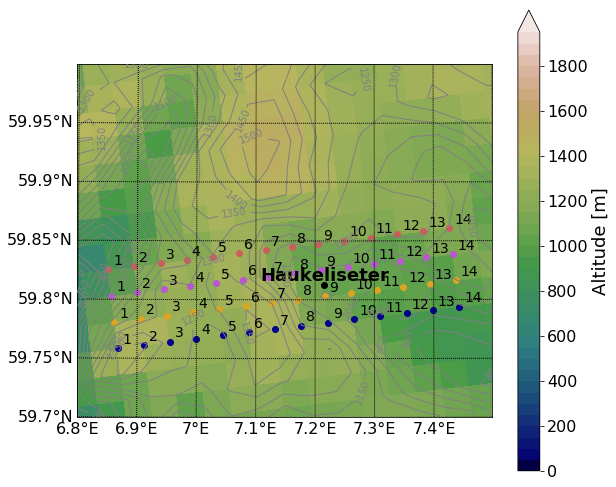

In [82]:
### Norway ###
#plt.figure(1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#map = Lambert_map(lllon=0., lllat=49., urlon=50., urlat=72, lat0= 63.5, lon0= 15, res='l', fill=True,zoom=False)
#map = Lambert_map(lllon=longitude[0,:].min(), lllat=latitude[0,:].min(), 
 #                urlon=longitude[-1,:].max(), urlat=latitude[-1,:].max(), 
  #               lat0= 63.5, lon0= 15, res='l', fill=True,zoom=False)
map = Lambert_map(lllon=6.8, lllat=59.7, 
                  urlon=7.5, urlat=60., 
                  lat0= stn_lat, lon0= stn_lon, res='l', fill=True,zoom=True)

Lonpp,Latpp = map(longitude,latitude)
#alti[alti<3] = np.nan
#PlotContours(Lonpp, Latpp, alti, map, leveldist=None,levels=[0, 25, 50, 100, 200, 300, 400, 500, 600,1000,1500,2000], numbers=True, color= 'k')
#PlotColorMap4(Lonpp, Latpp, alti, map, bounds= [3, 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1250, 1500,],color='red', label='Altitude')

levels = np.arange(0,np.nanmax(alti),50)
norm = colors.BoundaryNorm(boundaries = levels, ncolors=plt.cm.gist_earth.N)

#cs = map.contourf(Lonpp, Latpp, alti, levels, norm=norm, cmap = plt.cm.gist_earth, extend='max')
cs = map.pcolormesh(Lonpp, Latpp, alti,cmap=plt.cm.gist_earth)
cb = plt.colorbar(cs, boundaries= levels, #location='right',
                  extend='max')
cb.set_label('Altitude [m]', size=18)    
cb.ax.tick_params(labelsize=16)
plt.gca().set_aspect('equal', adjustable='box')

#levels = np.arange(700,1800,50)
PlotContours(Lonpp, Latpp, alti, map, leveldist=None, levels=levels, numbers=True,color='gray')

namestat = ['Haukeliseter']
lonstat = [7+12.87/60]#,7.2]
latstat= [59+48.73/60]#,59.8]



xpt, ypt= map(lonstat, latstat)
map.plot(xpt,ypt,'ko')
for i in range(len(namestat)):
    plt.text(xpt[i]+100, ypt[i]+100, namestat[i], fontsize=18,fontweight='bold', 
             ha='center',va='bottom',color='black')
#plt.tight_layout(pad=2.5)  


#x4, y4 = map(longitude[309,(np.array(xx)[~np.isnan(xx)]).astype(int)],
 #            latitude[309,(np.array(xx)[~np.isnan(xx)]).astype(int)])
#map.scatter(x4,y4)
#for i, (xl,yl) in enumerate(zip(x4, y4), start=1):
 #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

#x5, y5 = map(longitude[310,(np.array(xx)[~np.isnan(xx)]).astype(int)],
 #            latitude[310,(np.array(xx)[~np.isnan(xx)]).astype(int)])
#map.scatter(x5,y5)
#for i, (xl,yl) in enumerate(zip(x5, y5), start=1):
 #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

    
#x6, y6 = map(longitude[311,(np.array(xx)[~np.isnan(xx)]).astype(int)],
 #            latitude[311,(np.array(xx)[~np.isnan(xx)]).astype(int)])
#map.scatter(x6,y6)
#for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
 #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
    
    
###############################    
x4, y4 = map(longi[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
             lati[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
map.scatter(x4,y4, c = 'darkblue')
for i, (xl,yl) in enumerate(zip(x4, y4), start=1):
    ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
###############################
x5, y5 = map(longi[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
             lati[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
map.scatter(x5,y5, c = 'goldenrod')
for i, (xl,yl) in enumerate(zip(x5, y5), start=1):
    ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

###############################    
x6, y6 = map(longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
             lati[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
map.scatter(x6,y6, c = 'mediumorchid')
for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
    ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
###############################    
x6, y6 = map(longi[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
             lati[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
map.scatter(x6,y6,c = 'indianred')
for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
    ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
    
if savefig == 1:
    cF.createFolder('%s/' %(figdir))
#    fig_name = 'winter_16_17_obs_hist_dens'
    fig_name = 'cross_section'
    plt.savefig('%s/%s.%s' %(figdir, fig_name,form), format = form, bbox_inches ='tight')
    print('plot saved: %s/%s' %(figdir, fig_name))
else:
    plt.show()

In [62]:
######## with Vertical Levels ( hybrid )#################################
## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
# formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
# positive: down


### variables to calculate pressure
#p0 = fn.variables['p0']    ## p0: p0

ap = fn[2].variables['ap'][:]    ## ap: ap
b = fn[2].variables['b'] [:]     ## b: b


surface_air_pressure = fn[1].variables['surface_air_pressure'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1 ,
                                                               (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
air_temperature_0m   = fn[1].variables['air_temperature_0m'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                             (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
air_temperature_ml   = fn[2].variables['air_temperature_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                             (np.array(xx2)[~np.isnan(xx2)]).astype(int)]



upward_air_velocity_ml         = fn[2].variables['upward_air_velocity_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                           (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
height2                        = fn[2].variables['height2'][:]
brunt_vaisala_frequency_in_air = fn[2].variables['brunt_vaisala_frequency_in_air'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                                   (np.array(xx2)[~np.isnan(xx2)]).astype(int)]

#for i in range(1,np.shape(met_files)[0]):
 #   fn[i].close()

In [66]:
### Transfer pressure coordinate
p_interface = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0],
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]) )
p_interface[:] = np.nan

p_interfaces2 = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0]+1,
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]) )
p_interfaces2[:] = np.nan

p_ml = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0],
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
p_ml[:] = np.nan

p_ml2 = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0]+1,
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
p_ml2[:] = np.nan

temperature_ml = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0]+1,
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
temperature_ml[:] = np.nan

dz = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0],
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
dz[:] = np.nan

dgeop = np.empty(shape = (surface_air_pressure.shape[0],
                                ap.shape[0],
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
dgeop[:] = np.nan
#for k,l in zip( range(surface_air_pressure.shape[2]), range(surface_air_pressure.shape[3])):
for k in range(surface_air_pressure.shape[2]):
    for l in range(surface_air_pressure.shape[3]):
        p_interface[:,:,k,l] = ap[:]+b[:]*surface_air_pressure[:,:,k,l]


    ### 1) Connect interface values and surface values for pressure
    ### Pressure
        p_interfaces2[:,:,k,l] = np.concatenate((p_interface[:,:,k,l],surface_air_pressure[:,:,k,l]),axis=1)

    # transform hybrid sigma pressure coordinates at interface levels to pressure at model levels

        for i in range(0,p_interfaces2.shape[1]-1):
            p_ml[:,i,k,l] = 1/2 * (p_interfaces2[:,i,k,l] + p_interfaces2[:,i+1,k,l])
        p_ml2[:,:,k,l] = np.concatenate((p_ml[:,:,k,l],surface_air_pressure[:,:,k,l]),axis=1)

    ### --> Now the pressure is calculated at each model level

    ### 2) Connect model levels and surface values for temperature
    ### Temperature
        temperature_ml[:,:,k,l] = np.concatenate((air_temperature_ml[:,:,k,l],
                                                air_temperature_0m[:,:,k,l]),axis=1)

        dz[:,:,k,l], dgeop[:,:,k,l] = rs.get_thickness(p_ml2[:,:,k,l], temperature_ml[:,:,k,l])

In [87]:
elevation = np.empty(shape=(surface_air_pressure.shape[0],
                                ap.shape[0],
                                surface_air_pressure.shape[2],
                                surface_air_pressure.shape[3]))
for l in range(surface_air_pressure.shape[3]):
    elevation[:,:,0,l] = (alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + dz[:,:,0,l])
    elevation[:,:,1,l] = (alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + dz[:,:,1,l])
    elevation[:,:,2,l] = (alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + dz[:,:,2,l])
    elevation[:,:,3,l] = (alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + dz[:,:,3,l])

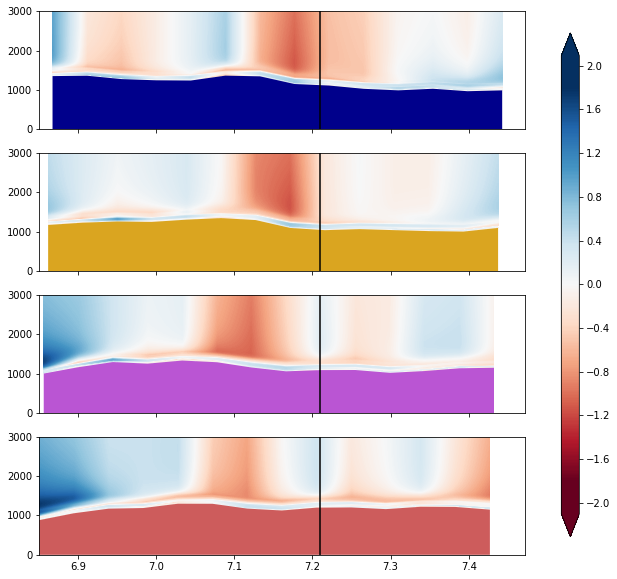

In [149]:
cmap = plt.get_cmap('RdBu')
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4,sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
norm = mpl.colors.Normalize(vmin=-1.8,vmax=1.8)

###################################
im = ax0.contourf(np.array([longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                  elevation[0,:,0,:], 
                  upward_air_velocity_ml[0,:,0,:],
                  cmap=cmap,norm=norm,
                  levels=np.arange(-2.1,2.1,0.01),  extend='both')
#fig.colorbar(im,ax=ax0,extend='both',ticks=np.arange(-2.,2.1,0.4))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax, extend='both',ticks=np.arange(-2.,2.1,0.4))
ax0.fill_between(longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 facecolor = 'darkblue')

ax0.set_ylim([0,3000])
ax0.vlines(7.21,0,3000)
###################################
im = ax1.contourf(np.array([longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                  elevation[0,:,1,:], 
                  upward_air_velocity_ml[0,:,1,:],
                  cmap=cmap,norm=norm,
                  levels=np.arange(-2.1,2.1,0.01),  extend='both')
#fig.colorbar(im,ax=ax1,extend='both',ticks=np.arange(-2.,2.1,0.4))
ax1.fill_between(longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],
                 facecolor = 'goldenrod')

ax1.set_ylim([0,3000])
ax1.vlines(7.21,0,3000)
###################################
im = ax2.contourf(np.array([longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                  elevation[0,:,2,:], 
                  upward_air_velocity_ml[0,:,2,:],
                  cmap=cmap,norm=norm,
                  levels=np.arange(-2.1,2.1,0.01),  extend='both')
#fig.colorbar(im,ax=ax2,extend='both',ticks=np.arange(-2.,2.1,0.4))
ax2.fill_between(longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 facecolor = 'mediumorchid')

ax2.set_ylim([0,3000])
ax2.vlines(7.21,0,3000)

###################################
im = ax3.contourf(np.array([longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                  elevation[0,:,3,:], 
                  upward_air_velocity_ml[0,:,3,:],
                  cmap=cmap,norm=norm,
                  levels=np.arange(-2.1,2.1,0.01),  extend='both')
#fig.colorbar(im,ax=ax3,extend='both',ticks=np.arange(-2.,2.1,0.4))
ax3.fill_between(longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                 facecolor = 'indianred')

ax3.set_ylim([0,3000])
ax3.vlines(7.21,0,3000)